In [1]:
import sys
print("python version: ", sys.version)

import pandas as pd
print("pandas version: ", pd.__version__)

import numpy as np
print('numpy version: ', np.__version__)

import scipy as sp
print('scipy version: ', sp.__version__)

import sklearn as skl
print('sklearn version: ', skl.__version__)

import matplotlib.pyplot as plt

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import keras as ks
print('keras version: ', ks.__version__)
print('keras backend: ', ks.backend.backend())

import tensorflow as tf
print('tensorflow version: ', tf.__version__)

import warnings
warnings.filterwarnings('ignore')

from keras import backend as K
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_recall_curve

import random

python version:  3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
pandas version:  0.24.2
numpy version:  1.16.4
scipy version:  1.3.0
sklearn version:  0.21.2


Using TensorFlow backend.


keras version:  2.2.4
keras backend:  tensorflow
tensorflow version:  1.14.0


In [2]:
excel_file = r'/home/kravchen/Desktop/NH/full_set.xlsx'
df = pd.DataFrame(pd.read_excel(excel_file))
print(df.shape)

(13142, 208)


In [3]:
df.head(n=10)

,patient-id,episode-start-date,episode-end-date,stay-start-date,stay-end-date,predictor-date,projected-date,current-stay-days,cumulative-days-in-facility,cms-long-stay,...,psych_sdd_3,psych_sdd_4,psych_sdd_5,psych_sdd_final,atc_1,atc_2,atc_3,atc_4,atc_5,number_of_behavior_changes
0,10353,2013-07-19 00:00:00,2013-08-19 00:00:00,2013-07-19 00:00:00,2013-08-19 00:00:00,2013-07-26 00:00:00,2013-08-19 00:00:00,7,7,No,...,1.333333,0.0,0,4.000000,N06AX21,N05BA12,N06AX05,NaN,NaN,0
1,10364,2013-08-07 00:00:00,2013-08-27 00:00:00,2013-08-07 00:00:00,2013-08-27 00:00:00,2013-08-14 00:00:00,2013-08-27 00:00:00,7,7,No,...,0.000000,0.0,0,0.166667,N05AH04,NaN,NaN,NaN,NaN,0
2,10379,2013-09-24 00:00:00,2013-10-15 00:00:00,2013-09-24 00:00:00,2013-10-15 00:00:00,2013-10-01 00:00:00,2013-10-15 00:00:00,7,7,No,...,0.000000,0.0,0,2.333333,N06AB04,N06AX05,NaN,NaN,NaN,0
3,10385,2013-10-12 00:00:00,2013-11-01 00:00:00,2013-10-12 00:00:00,2013-11-01 00:00:00,2013-10-19 00:00:00,2013-11-01 00:00:00,7,7,No,...,0.000000,0.0,0,3.000000,N06AB05,N06AX11,NaN,NaN,NaN,0
4,10386,2013-10-18 00:00:00,2013-10-29 00:00:00,2013-10-18 00:00:00,2013-10-29 00:00:00,2013-10-25 00:00:00,2013-10-29 00:00:00,7,7,No,...,0.000000,0.0,0,3.500000,N06AB06,N05AH03,NaN,NaN,NaN,0
5,5000,2012-04-25 00:00:00,2012-05-08 00:00:00,2012-04-25 00:00:00,2012-05-08 00:00:00,2012-05-02 00:00:00,2012-05-08 00:00:00,7,7,No,...,0.000000,0.0,0,0.500000,N06AX16,NaN,NaN,NaN,NaN,0
6,5003,2011-08-02 00:00:00,2011-08-24 00:00:00,2011-08-02 00:00:00,2011-08-24 00:00:00,2011-08-09 00:00:00,2011-08-24 00:00:00,7,7,No,...,0.000000,0.0,0,0.625000,N05AX08,N06AB04,NaN,NaN,NaN,0
7,5003,2011-08-02 00:00:00,2011-09-29 00:00:00,2011-09-05 00:00:00,2011-09-29 00:00:00,2011-09-12 00:00:00,2011-09-29 00:00:00,7,41,No,...,0.000000,0.0,0,1.125000,N05AX08,N06AB04,NaN,NaN,NaN,0
8,5007,2012-10-21 00:00:00,2012-11-15 00:00:00,2012-10-27 00:00:00,2012-11-15 00:00:00,2012-11-03 00:00:00,2012-11-15 00:00:00,7,13,No,...,0.000000,0.0,0,0.000000,NaN,NaN,NaN,NaN,NaN,0
9,5011,2012-06-12 00:00:00,2012-07-01 00:00:00,2012-06-12 00:00:00,2012-07-01 00:00:00,2012-06-19 00:00:00,2012-07-01 00:00:00,7,7,No,...,0.000000,0.0,0,0.000000,NaN,NaN,NaN,NaN,NaN,0


In [4]:
# Drop features
f_drop = ["Blank-1", "ws-sudden-stop", "ws-sudden-stop-drugs", "ws-prolonged-psychotropics", "mds-toilet-prgm-atmptd"] + \
         ['Deleted-%d' % i for i in range(1, 13)] + ['Psychotropic-%d' % i for i in range(1, 6)] + \
         ['Psychotropic-%d-average-daily-dose' % i for i in range(1, 6)] + ["Entry-discharge-type"]

# Missing value means not relevant
f_one_hot = ["Mds-fall-2-6-months-to-admission", "Mds-fall-last-month-to-admission", "mds-pain-last-five-days", \
             "mds-delirium-scale", "mds-long-term-memory-ok", "mds-short-term-memory-ok", "mds-staff-assess-pain", \
             "recent-start-other-fall-risk-rx"] + ["mds-pressure-ulcer-stage-%d" % i for i in range(1, 5)]
cate_one_hot = [['Yes', 'No', 'Unable to answer']] * 3 + [['Yes', 'No']] * 9

f_period = [("Psychotropic-%d-Start-date" % i, 'Psychotropic-%d-End-date' % i, 'Psychotropic-%d-Period' % i) for i in range(1, 6)]

f_label = ['mds-cognitive-scale', 'mds-pain-freq-last-five-days', 'mds-pain-intensity']
dic_label = [{'Independent': 0, 'Modified Independence': 1, 'Moderately Impaired': 2, 'Severely Impaired': 3}, \
             {'Continuous': 4, 'Frequent': 3, 'Occasional': 2, 'Rare': 1, 'Unable to respond': 0}, \
             {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Very severe, horrible': 4}]

f_transform = [('mds-cognitive-scale', 3, 0), ('mds-pain-freq-last-five-days', 4, 0), ('mds-pain-intensity', 4, 0)] + \
              [('Psychotropic-%d-Period' % i, 0, 0) for i in range(1, 6)]

In [5]:
# Encode features (originally) with no missing values
f_drop += ["predictor-date", "projected-date", "PPS-assessment", "Federal-assessment"]

f_period += [('episode-start-date', 'episode-end-date', 'episode-period'),\
             ('stay-start-date', 'stay-end-date', 'stay-period')]

f_label += ["cms-long-stay", "mds-stay-trans-short-to-long", "mds-antianxiety-medication", \
            "mds-antidepressant-medication", "mds-antipsychotic-medication", "mds-antibiotic-medication",
            "mds-anticoagulant-medication", "mds-diuretic-medication", \
            "mds-hypnotic-medication", "mds-behavioral-symptoms", "mds-behavioral-symptoms-to-others", \
            "mds-dehydrated", "mds-depression", "mds-fever", "mds-impaired-mobility", "mds-impaired-transfer", \
            "mds-internal-bleeding", "mds-malnutrition", "mds-no-problem-conditions", "mds-vomiting", \
            "mds-impaired-walk-in-room", "mds-impaired-walk-in-corridor", "mds-impaired-locomot-unit", \
            "mds-impaired-locomot-other", "ws-antibiotic-anticoag-coexposure", \
            "ws-psychotropic-with-not-ordered-weight-loss", \
            "ws-diuretic-adl", "ws-tramadol-antidepressant-coexposure"] + ["mds-pain-non-verbal"]
dic_label += [{'Yes': 1, 'No': 0}] * 28 + [{'None/Mild':0,'Moderate/Severe':1}]

f_one_hot += ["race", "facility", "gender", "mds-bims-summary-ranking", "ws-meclizine-psych-coexposure"]
cate_one_hot += [['White', 'Black', 'Other'], \
                 ['Sugar Creek', 'Heritage Place', 'Canterbury Place', 'Senaca Place', 'Cranberry Place'], \
                 ['Female', 'Male'], ['Intact or Moderately Intact', 'Moderate Impairment'], \
                 ['No', 'meclAndPsychStartSameR', 'meclPrecedesPsychR', 'psychPrecedesMeclR', 'meclAndPsychOlderStart']]

In [6]:
f_drop += ["min_effective_dose_%d" % i for i in range(1, 6)] + \
          ["Psychotropic-%d-average-daily-dose" % i for i in range(1, 6)] + \
          ["psych_sdd_%d" % i for i in range(1, 6)]

In [7]:
df['patient-id'] = df['patient-id'].astype('str')

In [8]:
list_pid = ['01c9bd28cd38934a6b6598c2f0c595e2','022c3df43beb87426fdc9e3aece863ed','028fedbb573c6bfa76fbde3cfef2aeee',
            '03af5cb05c302b9a8c2ccae1c91da4d0','0461c03862af4e50ce159a73f004b001','050e80396569549c813bd86878395edd',
            '059e7c93e64ac77e36a2e5837e48be77','05f01f0d1a7272b250d63cb579b1daf2','066a29d308fa4d898102a3e9f647de6f',
            '066ce145d5b174af066254e5be1585e2','0912055f2195755d7bef28609d049dd0','0f79f492f4c8473c31201ccd41f102b8',
            '125560598c5696e07f71c3f4da381d2f','135ceeb77bd08c60a947f74b9fd83d00','159cf0cc2acd9e91a05a523c7a152329',
            '16f552deb3c2ba571d073738cb554126','19632eeb65376617bd612503132285e2','1d46d1f923cfa7e3a7b23a737637981b',
            '1e15c99576756e3a1823a5f6aedd7f18','1fa6c165ef356f3252f06e7ca18c50fe','2085480e932df230b019761f6174200a',
            '2113f02d0df3a6963ff61e16bc4ad767','243bca59454a35fd31a80856898f4f08','28be643baa0fb455c9c311646f0041b8',
            '2a6db0f42c1d5d1c4f1342c5291b6c01','2b57427d702a8c4e375cd02fdd0cf387','2b6732124cae3953adecd89836537beb',
            '2d71fe90931c6e12ef800c4cba5377e3','3157f5db65d2f725c739a7ef98ec8b4e','32ac39841c469a47d86eb43abf35f3d5',
            '33eccc93bc55ba7619a6d1e333baf1f5','343df02f2dfc3c1ad6428e7e1c246585','37f069da79c11e4e9c01794b38bfa39f',
            '394f22d67bf57e6bfeebcf21242b38a5','3cff678dc116ea0c96bbc918057bc7c5','3d3fddbdfd3583a6d9d2c8e7f30c3cfb',
            '3d73b4edb7027ac1a8afd46ecc91e010','3df5c258d2032361615b2f9855bf554f','3e1f2a5ed144a2564c9857a530d25435',
            '4125a264d97877a301892fdd0f40431e','419328961cb5cf6fbaeb4178d2b77e46','4272f93c23b65e2c2a76a1daf8d40c43',
            '4b3fb60a20ef687a3f7c7d298467ee98','4cb9543864cb8cbe3e4bd66b0928b3f3','4cf06d285a6c3ca4591603c22536e2f0',
            '4d0739e22fc57d8cee62ad1d07ae1dd8','4e9a52901f6c1c38f0651378a4b60c61','50c824b1d52dc56df894d991f2ec46a8',
            '528ba7513e8a789dbb47ef90ccd861ac','58cc1f6d463a9034a9cf51c1f7e50804','5914c3856eba88d19500ce0cafd35ef1',
            '59545dcc4048310c4b8f09269ac7ce07','5a5aaba2d783818513a3cf640a18720a','5e3e1d07b47dac2ced35258ae59ff686',
            '602dd3b3ef35189913b236748df90361','606aa687675a9ea23d9b9a7329e1ca89','61422cfa73ea89c6d0b0268b6c89e492',
            '617487bcc3dc2194fd094ea86e0e49e9','6219b2510e1b28eb0a7f48c3f7fdb52c','63f1056a29e7b12278e41d0f13f59de6',
            '64badf6afcc2b2e7b2288c17d74af035','65d7aa76dc841c84dfa376ed2bff6d65','6879012f2cf2f93673a2793ccf09c616',
            '69439f6799adc0ecebe5d8062ce0db5b','6b037a194ef4976eeb4803b62c4fb719','7040cd5b48783e42bf69ad8ae1130db5',
            '73a5736925da1fdb859ab54bfdedbfff','7419e251e895417a3a3ad7e47f688b29','774354380b368224856c600805762b03',
            '778606017ea378b29c4235662dd77a9b','781c7032ce133dd852b96ccd2d11e4bf','7f7464781c2b59b1979ed129ba5866ef',
            '8255666eee1ff0e1738dbd63d47ab6aa','83fd66c1795678c3116e9398298fe73a','84ee1eaf7070d3a9c2bca4e4bc041bf2',
            '87bc682f79ea761ddbdbb013050a1c5b','87c81ea150ff908dde537131cd2b8678','890b8e1488a926c3d61ca5cdf269c042',
            '898b48ced3f1e9dd37295d534c53a39d','8bb9b6b57afd916d9cbd154b58aee93a','8f497041c5cc920c1189c006b02be284',
            '8fe7afaf70fc15b77f5a4a45076db512','91042073096161389f78bcf12b373ac8','922c7f6d9b7ada7bf349b9ca9e0690c8',
            '927974d7535434e1dcf3c7cfba4b9493','94b51da11d9030efe8f0ae2a258b5249','958fcb3de326daceb8bca6f71c7f5f31',
            '974cabadc622c98bacb02e0c11cca489','97d6876c1ab25f3b1b157afea04ce085','991e202dbf8f3fa69c5bea40e4e22d32',
            '9ba083b4aeef838bb60273a1d85c51e8','9c83331eaf085e5226215fa8b0183264','a19c4a24fd629208c04e8da5226c18ec',
            'a2f272d11c96df42d2163777bc8b9530','a7bc2122f362b14549d93cc3f888211c','a91c38bf9a58e1f03b7d88d952183175',
            'ab2bc61274221eb593838366c4046d4e','b70b10fecd0dc4459b5f79fe1c27a066','ba04153243cd16383154dd03c3ab3d3d',
            'bb95450097bf3c9225491ab15f23bcbe','bbc54ea74865d7a669648770bec1a8ed','bbf942add1eb11d25de4bcd587255e8d',
            'bcd63981899e769ab4986af9cf68ecbc','bde50fe656168818a77249c148a49889','bdef2cfe5abcfbd00ec4e89bbdecdb4c',
            'be39412453a33d32d0cbc6fa2212e28f','bfcd1ac21134401a12e49a4d6be167a3','bfea8bd973b40144d41ecb96a463991a',
            'bff2ebb09d73c89167241250440c475e','c0adcc870ca075369537f7cd0877576a','c43e268913b76a1459b065476b86e2ff',
            'c45f458bc9561029985c973235627185','c4ba9f5f0b6ae3cfedc6bbc8a3b2c2a0','c4d2a7f360cd8f7b22cd7cf748b83ec7',
            'c8cec1bb3ccdb5e85d4a2068d81055b0','c9c7312b0816720c953a449dc3007635','cab79650794648699c676a3d19cdb009',
            'cb0166129d1c010d264776aef3b55510','ccc01717be747dd7d59a19ee79544b0a','cdb953820470775894008c4cb16c2c17',
            'd16aaa7f5eca772d64e756821630ec7f','d27c1300551cd5163d6f895adbba91cd','d42790b38a297d4f424f5c6503d99d62',
            'd5d7628be40c7cf6ebe8246a46f8038a','d7edbb8d7813c32bb838a90e7c485b2b','da853215664367774c410210e67d1028',
            'de9c1b2cf691af973ae00cc2d8e3ec15','e1ff6970a403794a37514b93e34a111f','e2283dc2db45396b4c6cce396168a8bf',
            'e2c6a76355fa923cd66d93359c3bd938','e38e043f8c26f5c4a6ec970bda188474','e414586b30c0b6d57a34ea69e0c30c0e',
            'e647db52770cc1af0cb377543b4eb303','e7567ff5caecf54f0ff222be914725dc','ea7455ba2d24883ea75b5b8213bb5569',
            'eb1c1a8c716fb70f25f745ebbc3b3b8f','eb1f2d920e97bb91ad6c9fdb809838fa','ef70587998eb7bc12c6466c36590a539',
            'effff673ae3df86f25970195d9fcf269','f5859bf3807ff3daa51967cce30a8d17','f967b6504968aaee43c2c6ac6ec3234a',
            'fc636cef2e6ea2fe9d9db02eeb673d11'] 

In [9]:
df1 = df[~df['patient-id'].isin(list_pid)]

In [10]:
# generate target
target = df1['outcome-Mds-fall-since-prior-assessment'].map({'None': 0, 'Yes': 1})
dff = df1.drop(['outcome-mds-fall-no-injury', 'outcome-mds-fall-minor-injury', 'outcome-mds-fall-major-injury', \
               'outcome-Mds-fall-since-prior-assessment', 'outcome-riskmaster-fall-incident'], axis=1)

In [11]:
# in sdd 0 means NA
for i in range(1, 6):
    df.loc[df['psych_sdd_%d' % i] == 0, 'psych_sdd_%d' % i] = np.nan

In [12]:
# train test split
from sklearn.model_selection import GroupShuffleSplit
def train_test_split(df, target, groupby, radio, random_state):
    train_idx, test_idx = next(GroupShuffleSplit(train_size=radio, test_size=1-radio, random_state=random_state).split(df, target, df[groupby]))
    return df.iloc[train_idx], df.iloc[test_idx], target.iloc[train_idx], target.iloc[test_idx]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(dff, target, 'patient-id', 0.7, 0)
#print('Total number of patients: %d' % len(df.groupby('patient-id')))
#print('Number of patients in training set: %d' % len(X_train.groupby('patient-id')))

In [14]:
# drop feature
def drop_features(df, f):
    df.drop(f, axis=1, inplace=True)
    
# one hot encoding
def one_hot_encoding(df, features, categories):
    for f, c in zip(features, categories):
        df[f] = df[f].astype('category', categories=c)
    return pd.get_dummies(df, columns=features, prefix=features)

# compute date difference
def date_diff(start, end):
    return (pd.to_datetime(end) - pd.to_datetime(start)) / np.timedelta64(1, 'D')

# generate date diff features
def generate_period(df, f):
    for start, end, period in f:
        df[period] = date_diff(df[start], df[end])
        df.drop([start, end], axis=1, inplace=True)
        
# label encoding
def label_encoding(df, features, dictionaries):
    for f, dic in zip(features, dictionaries):
        df[f] = df[f].map(dic)
        
# sin&cos transform
def col_transform(df, col, mmax, mmin, df_ref=None):
    if(mmax <= mmin):
        # for test set, if max&min not set, use training set value
        if(df_ref is not None): 
            mmax = df_ref[col].max()
            mmin = df_ref[col].max()
        else:
            mmax = df[col].max()
            mmin = df[col].min()
    angle = 0.25 * np.pi * (df[col] - mmin) / (mmax - mmin) + 0.125 * np.pi
    return (np.cos(angle), np.sin(angle))

def df_transform(df, f, df_ref=None):
    for col, mmax, mmin in f:
        df[col + '_x'], df[col + '_y'] = col_transform(df, col, mmax, mmin, df_ref)
        df[col + '_x'].fillna(0, inplace=True)
        df[col + '_y'].fillna(0, inplace=True)
        df.drop(col, axis=1, inplace=True)

In [15]:
%%time
generate_period(X_train, f_period)
label_encoding(X_train, f_label, dic_label)
X_train_original = X_train.copy() # store value range
df_transform(X_train, f_transform)
X_train = one_hot_encoding(X_train, f_one_hot, cate_one_hot)
drop_features(X_train, f_drop)

CPU times: user 41.8 s, sys: 1.15 s, total: 42.9 s
Wall time: 15.1 s


In [16]:
X_train_use = X_train.copy()

In [17]:
%%time
generate_period(X_test, f_period)
label_encoding(X_test, f_label, dic_label)
df_transform(X_test, f_transform, X_train_original)
X_test = one_hot_encoding(X_test, f_one_hot, cate_one_hot)
drop_features(X_test, f_drop)

CPU times: user 13 s, sys: 20.3 ms, total: 13 s
Wall time: 12.1 s


In [18]:
X_test_use = X_test.copy()

In [19]:
X_train_use.shape

(8600, 189)

In [20]:
X_train_use.to_csv (r'/tmp/export_simpleRNN_exp1_train_dataframe.csv', index = False, header=True)

In [21]:
X_test_use.shape

(3692, 189)

**RNN - SimpleRNN**

In [22]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, Masking, TimeDistributed
from numpy.random import seed
from tensorflow import set_random_seed
from copy import deepcopy
from keras.preprocessing.sequence import pad_sequences

In [23]:
# missing data describe
def missing_summary(df):
    missing_cnt = df.isna().sum()
    missing_data = pd.concat([missing_cnt, missing_cnt/df.shape[0]], axis=1, keys=['count', 'percentage'])
    return missing_data[missing_data['percentage'] != 0].sort_values(by='percentage', ascending=False)

In [24]:
idx = missing_summary(X_train_use).index.tolist()
X_train_use.drop(columns=idx, axis=1, inplace=True)
X_test_use.drop(columns=idx, axis=1, inplace=True)

In [25]:
def scaler_transform(X_train_use, X_test_use):    
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X_train_use.drop('patient-id', axis=1))
    X_train_transformed = pd.DataFrame(scaler.transform(X_train_use.drop('patient-id', axis=1)), \
                                       columns=X_train_use.columns[1:], index=X_train_use.index)                                   
    X_train_transformed['patient-id'] = X_train_use['patient-id']
    X_test_transformed = pd.DataFrame(scaler.transform(X_test_use.drop('patient-id', axis=1)), \
                                       columns=X_test_use.columns[1:], index=X_test_use.index) 
    X_test_transformed['patient-id'] = X_test_use['patient-id']
    return X_train_transformed, X_test_transformed

In [26]:
def add_previous_outcome(X, Y):
    X = X.copy()
    x1, x2 = [], []
    pids = X['patient-id'].unique()
    for pid in pids:
        df = Y[X[X['patient-id']==pid].index]
        if(df.shape[0] == 1):
            x1.append(pd.Series([0]))
            x2.append(pd.Series([0]))
        else:
            # input 1=(1, 0), 0=(0, 1), NA=(0, 0)
            x1.append(pd.Series([0]))
            x1.append(df[:-1])
            x2.append(pd.Series([0]))
            x2.append(df[:-1].map({0: 1, 1: 0}))
    X['input_outcome_x'] = pd.Series(pd.concat(x1, ignore_index=True).tolist(), index=X.index)
    X['input_outcome_y'] = pd.Series(pd.concat(x2, ignore_index=True).tolist(), index=X.index)
    return X

In [27]:
## This step converts the outcome to a point in x,y coordinates where fall (1) = (1,0); no fall (0) = (0,1); and NA = (0,0) 
X_train_use = add_previous_outcome(X_train_use, y_train)
X_test_use = add_previous_outcome(X_test_use, y_test)

## This step transforms the data to range between 0 and 1
X_train_transformed, X_test_transformed = scaler_transform(X_train_use, X_test_use)

In [28]:
X_train_transformed.to_csv (r'/tmp/exp1_train_transformed_df.csv', index = False, header=True)

In [29]:
X_train_use.shape

(8600, 102)

In [30]:
X_test_use.shape

(3692, 102)

In [31]:
X_train_use.head()

,patient-id,current-stay-days,cumulative-days-in-facility,cms-long-stay,mds-stay-trans-short-to-long,age,mds-antianxiety-medication,mds-antidepressant-medication,mds-antipsychotic-medication,mds-antibiotic-medication,...,gender_Male,mds-bims-summary-ranking_Intact or Moderately Intact,mds-bims-summary-ranking_Moderate Impairment,ws-meclizine-psych-coexposure_No,ws-meclizine-psych-coexposure_meclAndPsychStartSameR,ws-meclizine-psych-coexposure_meclPrecedesPsychR,ws-meclizine-psych-coexposure_psychPrecedesMeclR,ws-meclizine-psych-coexposure_meclAndPsychOlderStart,input_outcome_x,input_outcome_y
0,10353,7,7,0,0,67,1,1,0,0,...,0,1,0,1,0,0,0,0,0,0
1,10364,7,7,0,1,84,0,0,1,1,...,0,1,0,1,0,0,0,0,0,0
2,10379,7,7,0,0,84,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0
5,5000,7,7,0,0,90,0,1,1,0,...,0,1,0,1,0,0,0,0,0,0
6,5003,7,7,0,1,90,0,1,1,1,...,1,1,0,1,0,0,0,0,0,0


In [32]:
X_train_transformed.head()

,current-stay-days,cumulative-days-in-facility,cms-long-stay,mds-stay-trans-short-to-long,age,mds-antianxiety-medication,mds-antidepressant-medication,mds-antipsychotic-medication,mds-antibiotic-medication,mds-anticoagulant-medication,...,mds-bims-summary-ranking_Intact or Moderately Intact,mds-bims-summary-ranking_Moderate Impairment,ws-meclizine-psych-coexposure_No,ws-meclizine-psych-coexposure_meclAndPsychStartSameR,ws-meclizine-psych-coexposure_meclPrecedesPsychR,ws-meclizine-psych-coexposure_psychPrecedesMeclR,ws-meclizine-psych-coexposure_meclAndPsychOlderStart,input_outcome_x,input_outcome_y,patient-id
0,0.007423,0.006342,0.0,0.0,0.558140,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10353
1,0.007423,0.006342,0.0,1.0,0.755814,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10364
2,0.007423,0.006342,0.0,0.0,0.755814,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10379
5,0.007423,0.006342,0.0,0.0,0.825581,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5000
6,0.007423,0.006342,0.0,1.0,0.825581,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5003


In [33]:
X_train_transformed.shape

(8600, 102)

In [34]:
def generate_nested_list(X, Y):
    x_list, y_list = [], [] 
    pids = X['patient-id'].unique()
    for pid in pids:
        df = X[X['patient-id']==pid]
        y_list.append(Y[df.index].values)
        x_list.append([record for record in df.drop('patient-id', axis=1).values])
    return x_list, y_list

def mygenerator(x_list, y_list=None):
    if(y_list is not None):
        while True:
            for x, y in zip(x_list, y_list):
                yield np.array(x).reshape((len(x), 1, x[0].shape[0])), y
    else:
        while True:
            for x in x_list:
                yield np.array(x).reshape((len(x), 1, x[0].shape[0])) 
                
def fit_model(model, epoch, X_train, y_train, X_valid=None, y_valid=None, verbose=0):
    history = model.fit(X_train, y_train, epochs=epoch, verbose=verbose)
    if(verbose != 0):
        plot_history(history)
    return history

def plot_roc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
def plot_history(history, loss=None, val_loss=None):
    if(history is not None):
        loss = history.history['loss']
    plt.figure()
    plt.plot(loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if('val_loss' in history.history):
        val_loss = history.history['val_loss']
        plt.plot(val_loss)
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [35]:
def pad_data(X, maxlen):
    return pad_sequences(X, maxlen=maxlen, dtype='float64', padding='post')

def pad_all(X_train, y_train, X_test, y_test, maxlen):
    return pad_data(X_train, maxlen), pad_data(y_train, maxlen), pad_data(X_test, maxlen), pad_data(y_test, maxlen)

In [36]:
def auroc(y_predict, y_true, plot=False):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1)    
    if(plot):
        plot_roc_curve(fpr, tpr)
    return auc(fpr, tpr)


def find_best_f1(y_predict, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1) 
    max_f1, th = 0, 0
    for threshold in thresholds:
        f1 = f1_score(y_true, y_predict > threshold)
        if(f1 > max_f1):
            max_f1 = f1
            th = threshold
    return max_f1, th

def other_metrics(y_predict, y_true, threshold):
    y_threshold = y_predict > threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_threshold).ravel()
    return precision_score(y_true, y_threshold), recall_score(y_true, y_threshold),\
            accuracy_score(y_true, y_threshold), float(tn) / (tn + fp)


In [50]:
from sklearn.model_selection import GroupKFold
def kfold_validation(unit, ratio, epoch, X, y, groupby, k=5, verbose=0, max_timestamps=20, n_features=98):
    auroc_list = []
    other_metric_list = []
    for train_idx, valid_idx in GroupKFold(n_splits=5).split(X, y, X[groupby]):
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
        X_train, y_train = generate_nested_list(X_train, y_train)
        X_valid, y_valid = generate_nested_list(X_valid, y_valid)
        X_train_pad, y_train_pad, X_valid_pad, y_valid_pad = pad_all(X_train, y_train, X_valid, y_valid, max_timestamps)
        y_train_pad = y_train_pad.reshape(y_train_pad.shape[0], y_train_pad.shape[1], 1)
        seed(1)
        set_random_seed(2)
        model = build_model(unit, ratio, max_timestamps, n_features)
        fit_model(model, epoch, X_train_pad, y_train_pad, verbose=verbose)
        y_valid_len = [len(y) for y in y_valid]
        y_predict = model.predict(X_valid_pad)
        y_predict = truncate_prediction(y_predict, y_valid_len)
        y_true = np.concatenate(y_valid)
        auroc_list.append(auroc(y_predict, y_true))
        f1, th = find_best_f1(y_predict, y_true)
        precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
        other_metric_list.append((precision, recall, accuracy, specificity,f1,th))
    return (auroc_list, other_metric_list) 

In [51]:
# %%time
# shape: (num_of_patients, num_of_records, num_of_features)
X_train_list, y_train_list = generate_nested_list(X_train_transformed, y_train)
X_test_list, y_test_list = generate_nested_list(X_test_transformed, y_test)

In [52]:
#[len(x) for x in X_train_list[0:200]]

In [53]:
#X_train_list[4]

In [54]:
max_timestamps = df.groupby(['patient-id']).size().max()
print(max_timestamps)

20


In [55]:
n_features = X_train_list[0][0].shape[0]
print(n_features)

101


In [56]:
## Use a SimpleRNN to compare with the LSTM runs
from keras import regularizers
from keras.optimizers import Adagrad, Adadelta
def build_model(units, dropout_ratio, n_timesteps, n_dimensions):
    model = Sequential()
    model.add(Masking(input_shape=(n_timesteps, n_dimensions)))
    model.add(SimpleRNN(units, return_sequences=True, recurrent_dropout=dropout_ratio, dropout=0.5))
    model.add(TimeDistributed(Dense(1, activation='sigmoid')))
    model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['binary_accuracy'])
    return model

In [57]:
def truncate_prediction(y_, y_len):
    y_concat = []
    for i, y in enumerate(y_):
        y_concat.append(np.concatenate(y[:y_len[i], :]))
    y_concat = np.concatenate(y_concat)
    return y_concat

In [58]:
X_train_pad, y_train_pad, X_test_pad, y_test_pad = pad_all(X_train_list, y_train_list, X_test_list, y_test_list, max_timestamps)
#y_train_pad = y_train_pad.reshape((2193, 19, 1))

In [59]:
y_train_pad.shape

(3332, 20)

In [60]:
y_train_pad = y_train_pad.reshape((3332, 20, 1))

In [61]:
len(X_train_list[1])

1

In [62]:
len(X_train_pad[0])

20

W0522 02:40:35.826127 140076419147584 deprecation_wrapper.py:119] From /usr/local/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0522 02:40:35.829263 140076419147584 deprecation_wrapper.py:119] From /usr/local/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0522 02:40:35.845080 140076419147584 deprecation_wrapper.py:119] From /usr/local/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0522 02:40:35.889960 140076419147584 deprecation_wrapper.py:119] From /usr/local/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_

Epoch 1/175
3332/3332 [==============================] - 2s 666us/step - loss: 0.4371 - binary_accuracy: 0.8343
Epoch 2/175
3332/3332 [==============================] - 1s 414us/step - loss: 0.4243 - binary_accuracy: 0.8387
Epoch 3/175
3332/3332 [==============================] - 1s 406us/step - loss: 0.4191 - binary_accuracy: 0.8402
Epoch 4/175
3332/3332 [==============================] - 1s 443us/step - loss: 0.4165 - binary_accuracy: 0.8404
Epoch 5/175
3332/3332 [==============================] - 1s 400us/step - loss: 0.4145 - binary_accuracy: 0.8418
Epoch 6/175
3332/3332 [==============================] - 1s 427us/step - loss: 0.4130 - binary_accuracy: 0.8400
Epoch 7/175
3332/3332 [==============================] - 2s 462us/step - loss: 0.4155 - binary_accuracy: 0.8400
Epoch 8/175
3332/3332 [==============================] - 2s 514us/step - loss: 0.4114 - binary_accuracy: 0.8395
Epoch 9/175
3332/3332 [==============================] - 2s 522us/step - loss: 0.4117 - binary_accuracy:

3332/3332 [==============================] - 2s 487us/step - loss: 0.3994 - binary_accuracy: 0.8411
Epoch 146/175
3332/3332 [==============================] - 2s 483us/step - loss: 0.3991 - binary_accuracy: 0.8432
Epoch 147/175
3332/3332 [==============================] - 2s 471us/step - loss: 0.4008 - binary_accuracy: 0.8402
Epoch 148/175
3332/3332 [==============================] - 2s 510us/step - loss: 0.4013 - binary_accuracy: 0.8439
Epoch 149/175
3332/3332 [==============================] - 2s 479us/step - loss: 0.4007 - binary_accuracy: 0.8414
Epoch 150/175
3332/3332 [==============================] - 2s 471us/step - loss: 0.4021 - binary_accuracy: 0.8421
Epoch 151/175
3332/3332 [==============================] - 2s 470us/step - loss: 0.3982 - binary_accuracy: 0.8440
Epoch 152/175
3332/3332 [==============================] - 2s 467us/step - loss: 0.3967 - binary_accuracy: 0.8427
Epoch 153/175
3332/3332 [==============================] - 2s 470us/step - loss: 0.3992 - binary_accur

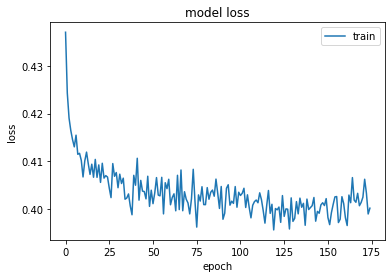

auroc:  0.7511690587939545
f1:  0.45293701344656756
threshold:  0.17052066
precision:  0.39408866995073893
recall:  0.5324459234608985
accuracy:  0.7906283856988082
specificity:  0.8408282109349725
CPU times: user 9min 49s, sys: 1min 51s, total: 11min 40s
Wall time: 4min 47s


In [63]:
%%time
### A single run w/out cross-validation
# with previous outcome added to the features
# outcome is added before scaling
seed(1)
set_random_seed(2)
model = build_model(32, 0.5, max_timestamps, n_features)
fit_model(model, 175, X_train_pad, y_train_pad, verbose=1)
y_predict = model.predict(X_test_pad)
y_test_len = [len(y) for y in y_test_list]
y_predict = truncate_prediction(y_predict, y_test_len)
y_true = np.concatenate(y_test_list)
print('auroc: ', auroc(y_predict, y_true))
f1, th = find_best_f1(y_predict, y_true)
print('f1: ', f1);
print('threshold: ', th)
precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)
print('specificity: ', specificity)

Epoch 1/225
2666/2666 [==============================] - 2s 685us/step - loss: 0.4440 - binary_accuracy: 0.8313
Epoch 2/225
2666/2666 [==============================] - 1s 384us/step - loss: 0.4242 - binary_accuracy: 0.8405
Epoch 3/225
2666/2666 [==============================] - 1s 384us/step - loss: 0.4241 - binary_accuracy: 0.8365
Epoch 4/225
2666/2666 [==============================] - 1s 464us/step - loss: 0.4254 - binary_accuracy: 0.8414
Epoch 5/225
2666/2666 [==============================] - 1s 468us/step - loss: 0.4215 - binary_accuracy: 0.8391
Epoch 6/225
2666/2666 [==============================] - 1s 389us/step - loss: 0.4173 - binary_accuracy: 0.8404
Epoch 7/225
2666/2666 [==============================] - 1s 387us/step - loss: 0.4211 - binary_accuracy: 0.8362
Epoch 8/225
2666/2666 [==============================] - 1s 351us/step - loss: 0.4111 - binary_accuracy: 0.8390
Epoch 9/225
2666/2666 [==============================] - 1s 460us/step - loss: 0.4180 - binary_accuracy:

2666/2666 [==============================] - 1s 344us/step - loss: 0.4060 - binary_accuracy: 0.8380
Epoch 146/225
2666/2666 [==============================] - 1s 326us/step - loss: 0.4066 - binary_accuracy: 0.8396
Epoch 147/225
2666/2666 [==============================] - 1s 331us/step - loss: 0.4028 - binary_accuracy: 0.8404
Epoch 148/225
2666/2666 [==============================] - 1s 332us/step - loss: 0.4030 - binary_accuracy: 0.8404
Epoch 149/225
2666/2666 [==============================] - 1s 344us/step - loss: 0.4064 - binary_accuracy: 0.8385
Epoch 150/225
2666/2666 [==============================] - 1s 331us/step - loss: 0.4051 - binary_accuracy: 0.8392
Epoch 151/225
2666/2666 [==============================] - 1s 342us/step - loss: 0.4043 - binary_accuracy: 0.8437
Epoch 152/225
2666/2666 [==============================] - 1s 338us/step - loss: 0.4065 - binary_accuracy: 0.8364
Epoch 153/225
2666/2666 [==============================] - 1s 341us/step - loss: 0.4027 - binary_accur

Epoch 217/225
2666/2666 [==============================] - 1s 349us/step - loss: 0.4018 - binary_accuracy: 0.8405
Epoch 218/225
2666/2666 [==============================] - 1s 345us/step - loss: 0.4012 - binary_accuracy: 0.8412
Epoch 219/225
2666/2666 [==============================] - 1s 344us/step - loss: 0.4008 - binary_accuracy: 0.8405
Epoch 220/225
2666/2666 [==============================] - 1s 350us/step - loss: 0.4023 - binary_accuracy: 0.8399
Epoch 221/225
2666/2666 [==============================] - 1s 346us/step - loss: 0.4047 - binary_accuracy: 0.8367
Epoch 222/225
2666/2666 [==============================] - 1s 344us/step - loss: 0.4045 - binary_accuracy: 0.8403
Epoch 223/225
2666/2666 [==============================] - 1s 348us/step - loss: 0.4009 - binary_accuracy: 0.8410
Epoch 224/225
2666/2666 [==============================] - 1s 345us/step - loss: 0.4031 - binary_accuracy: 0.8410
Epoch 225/225
2666/2666 [==============================] - 1s 345us/step - loss: 0.4016 

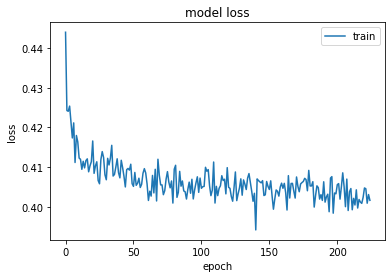

Epoch 1/225
2666/2666 [==============================] - 2s 649us/step - loss: 0.4420 - binary_accuracy: 0.8317
Epoch 2/225
2666/2666 [==============================] - 1s 338us/step - loss: 0.4291 - binary_accuracy: 0.8375
Epoch 3/225
2666/2666 [==============================] - 1s 344us/step - loss: 0.4208 - binary_accuracy: 0.8387
Epoch 4/225
2666/2666 [==============================] - 1s 336us/step - loss: 0.4182 - binary_accuracy: 0.8393
Epoch 5/225
2666/2666 [==============================] - 1s 353us/step - loss: 0.4196 - binary_accuracy: 0.8414
Epoch 6/225
2666/2666 [==============================] - 1s 344us/step - loss: 0.4193 - binary_accuracy: 0.8413
Epoch 7/225
2666/2666 [==============================] - 1s 356us/step - loss: 0.4147 - binary_accuracy: 0.8422
Epoch 8/225
2666/2666 [==============================] - 1s 339us/step - loss: 0.4148 - binary_accuracy: 0.8406
Epoch 9/225
2666/2666 [==============================] - 1s 355us/step - loss: 0.4106 - binary_accuracy:

2666/2666 [==============================] - 1s 347us/step - loss: 0.4020 - binary_accuracy: 0.8412
Epoch 146/225
2666/2666 [==============================] - 1s 394us/step - loss: 0.3940 - binary_accuracy: 0.8452
Epoch 147/225
2666/2666 [==============================] - 1s 333us/step - loss: 0.4009 - binary_accuracy: 0.8445
Epoch 148/225
2666/2666 [==============================] - 1s 338us/step - loss: 0.3942 - binary_accuracy: 0.8451
Epoch 149/225
2666/2666 [==============================] - 1s 336us/step - loss: 0.4035 - binary_accuracy: 0.8386
Epoch 150/225
2666/2666 [==============================] - 1s 353us/step - loss: 0.4054 - binary_accuracy: 0.8411
Epoch 151/225
2666/2666 [==============================] - 1s 383us/step - loss: 0.4031 - binary_accuracy: 0.8408
Epoch 152/225
2666/2666 [==============================] - 1s 350us/step - loss: 0.4001 - binary_accuracy: 0.8424
Epoch 153/225
2666/2666 [==============================] - 1s 398us/step - loss: 0.4018 - binary_accur

Epoch 217/225
2666/2666 [==============================] - 1s 350us/step - loss: 0.4007 - binary_accuracy: 0.8423
Epoch 218/225
2666/2666 [==============================] - 1s 415us/step - loss: 0.3972 - binary_accuracy: 0.8438
Epoch 219/225
2666/2666 [==============================] - 1s 363us/step - loss: 0.4022 - binary_accuracy: 0.8430
Epoch 220/225
2666/2666 [==============================] - 1s 361us/step - loss: 0.4006 - binary_accuracy: 0.8394
Epoch 221/225
2666/2666 [==============================] - 1s 334us/step - loss: 0.4018 - binary_accuracy: 0.8430
Epoch 222/225
2666/2666 [==============================] - 1s 346us/step - loss: 0.3965 - binary_accuracy: 0.8432
Epoch 223/225
2666/2666 [==============================] - 1s 353us/step - loss: 0.3980 - binary_accuracy: 0.8433
Epoch 224/225
2666/2666 [==============================] - 1s 357us/step - loss: 0.3983 - binary_accuracy: 0.8424
Epoch 225/225
2666/2666 [==============================] - 1s 334us/step - loss: 0.3997 

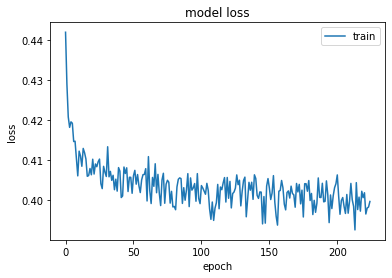

Epoch 1/225
2666/2666 [==============================] - 2s 685us/step - loss: 0.4533 - binary_accuracy: 0.8278
Epoch 2/225
2666/2666 [==============================] - 1s 405us/step - loss: 0.4251 - binary_accuracy: 0.8383
Epoch 3/225
2666/2666 [==============================] - 1s 364us/step - loss: 0.4255 - binary_accuracy: 0.8380
Epoch 4/225
2666/2666 [==============================] - 1s 344us/step - loss: 0.4207 - binary_accuracy: 0.8403
Epoch 5/225
2666/2666 [==============================] - 1s 344us/step - loss: 0.4196 - binary_accuracy: 0.8371
Epoch 6/225
2666/2666 [==============================] - 1s 340us/step - loss: 0.4185 - binary_accuracy: 0.8387
Epoch 7/225
2666/2666 [==============================] - 1s 362us/step - loss: 0.4148 - binary_accuracy: 0.8372
Epoch 8/225
2666/2666 [==============================] - 1s 340us/step - loss: 0.4168 - binary_accuracy: 0.8382
Epoch 9/225
2666/2666 [==============================] - 1s 345us/step - loss: 0.4154 - binary_accuracy:

2666/2666 [==============================] - 1s 364us/step - loss: 0.4021 - binary_accuracy: 0.8379
Epoch 146/225
2666/2666 [==============================] - 1s 422us/step - loss: 0.4002 - binary_accuracy: 0.8398
Epoch 147/225
2666/2666 [==============================] - 1s 403us/step - loss: 0.4071 - binary_accuracy: 0.8395
Epoch 148/225
2666/2666 [==============================] - 1s 379us/step - loss: 0.4046 - binary_accuracy: 0.8406
Epoch 149/225
2666/2666 [==============================] - 1s 429us/step - loss: 0.4033 - binary_accuracy: 0.8393
Epoch 150/225
2666/2666 [==============================] - 1s 381us/step - loss: 0.4016 - binary_accuracy: 0.8391
Epoch 151/225
2666/2666 [==============================] - 1s 382us/step - loss: 0.4007 - binary_accuracy: 0.8400
Epoch 152/225
2666/2666 [==============================] - 1s 457us/step - loss: 0.4051 - binary_accuracy: 0.8384
Epoch 153/225
2666/2666 [==============================] - 1s 438us/step - loss: 0.4017 - binary_accur

Epoch 217/225
2666/2666 [==============================] - 1s 331us/step - loss: 0.4049 - binary_accuracy: 0.8394
Epoch 218/225
2666/2666 [==============================] - 1s 346us/step - loss: 0.3970 - binary_accuracy: 0.8429
Epoch 219/225
2666/2666 [==============================] - 1s 348us/step - loss: 0.4050 - binary_accuracy: 0.8385
Epoch 220/225
2666/2666 [==============================] - 1s 354us/step - loss: 0.4025 - binary_accuracy: 0.8371
Epoch 221/225
2666/2666 [==============================] - 1s 343us/step - loss: 0.3996 - binary_accuracy: 0.8381
Epoch 222/225
2666/2666 [==============================] - 1s 344us/step - loss: 0.3950 - binary_accuracy: 0.8453
Epoch 223/225
2666/2666 [==============================] - 1s 342us/step - loss: 0.4043 - binary_accuracy: 0.8382
Epoch 224/225
2666/2666 [==============================] - 1s 373us/step - loss: 0.3965 - binary_accuracy: 0.8396
Epoch 225/225
2666/2666 [==============================] - 1s 361us/step - loss: 0.4019 

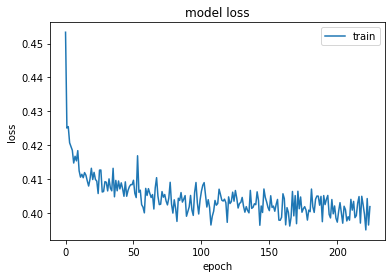

Epoch 1/225
2665/2665 [==============================] - 2s 713us/step - loss: 0.4368 - binary_accuracy: 0.8364
Epoch 2/225
2665/2665 [==============================] - 1s 356us/step - loss: 0.4197 - binary_accuracy: 0.8414
Epoch 3/225
2665/2665 [==============================] - 1s 351us/step - loss: 0.4152 - binary_accuracy: 0.8446
Epoch 4/225
2665/2665 [==============================] - 1s 356us/step - loss: 0.4130 - binary_accuracy: 0.8437
Epoch 5/225
2665/2665 [==============================] - 1s 354us/step - loss: 0.4098 - binary_accuracy: 0.8455
Epoch 6/225
2665/2665 [==============================] - 1s 347us/step - loss: 0.4093 - binary_accuracy: 0.8435
Epoch 7/225
2665/2665 [==============================] - 1s 360us/step - loss: 0.4055 - binary_accuracy: 0.8460
Epoch 8/225
2665/2665 [==============================] - 1s 355us/step - loss: 0.4019 - binary_accuracy: 0.8452
Epoch 9/225
2665/2665 [==============================] - 1s 348us/step - loss: 0.4049 - binary_accuracy:

2665/2665 [==============================] - 1s 339us/step - loss: 0.3941 - binary_accuracy: 0.8454
Epoch 146/225
2665/2665 [==============================] - 1s 339us/step - loss: 0.3928 - binary_accuracy: 0.8465
Epoch 147/225
2665/2665 [==============================] - 1s 336us/step - loss: 0.3918 - binary_accuracy: 0.8451
Epoch 148/225
2665/2665 [==============================] - 1s 338us/step - loss: 0.3936 - binary_accuracy: 0.8453
Epoch 149/225
2665/2665 [==============================] - 1s 336us/step - loss: 0.3943 - binary_accuracy: 0.8457
Epoch 150/225
2665/2665 [==============================] - 1s 338us/step - loss: 0.3943 - binary_accuracy: 0.8471
Epoch 151/225
2665/2665 [==============================] - 1s 339us/step - loss: 0.3964 - binary_accuracy: 0.8479
Epoch 152/225
2665/2665 [==============================] - 1s 337us/step - loss: 0.3954 - binary_accuracy: 0.8458
Epoch 153/225
2665/2665 [==============================] - 1s 337us/step - loss: 0.3965 - binary_accur

Epoch 217/225
2665/2665 [==============================] - 1s 333us/step - loss: 0.3913 - binary_accuracy: 0.8437
Epoch 218/225
2665/2665 [==============================] - 1s 337us/step - loss: 0.3965 - binary_accuracy: 0.8460
Epoch 219/225
2665/2665 [==============================] - 1s 334us/step - loss: 0.3962 - binary_accuracy: 0.8452
Epoch 220/225
2665/2665 [==============================] - 1s 338us/step - loss: 0.3893 - binary_accuracy: 0.8501
Epoch 221/225
2665/2665 [==============================] - 1s 347us/step - loss: 0.3985 - binary_accuracy: 0.8453
Epoch 222/225
2665/2665 [==============================] - 1s 340us/step - loss: 0.3951 - binary_accuracy: 0.8446
Epoch 223/225
2665/2665 [==============================] - 1s 338us/step - loss: 0.3958 - binary_accuracy: 0.8472
Epoch 224/225
2665/2665 [==============================] - 1s 332us/step - loss: 0.3918 - binary_accuracy: 0.8494
Epoch 225/225
2665/2665 [==============================] - 1s 333us/step - loss: 0.3970 

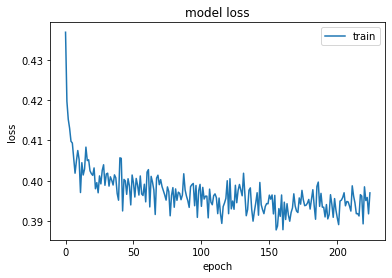

Epoch 1/225
2665/2665 [==============================] - 2s 737us/step - loss: 0.4395 - binary_accuracy: 0.8353
Epoch 2/225
2665/2665 [==============================] - 1s 346us/step - loss: 0.4185 - binary_accuracy: 0.8406
Epoch 3/225
2665/2665 [==============================] - 1s 347us/step - loss: 0.4137 - binary_accuracy: 0.8405
Epoch 4/225
2665/2665 [==============================] - 1s 348us/step - loss: 0.4099 - binary_accuracy: 0.8422
Epoch 5/225
2665/2665 [==============================] - 1s 346us/step - loss: 0.4089 - binary_accuracy: 0.8404
Epoch 6/225
2665/2665 [==============================] - 1s 346us/step - loss: 0.4104 - binary_accuracy: 0.8446
Epoch 7/225
2665/2665 [==============================] - 1s 346us/step - loss: 0.4041 - binary_accuracy: 0.8459
Epoch 8/225
2665/2665 [==============================] - 1s 346us/step - loss: 0.4058 - binary_accuracy: 0.8453
Epoch 9/225
2665/2665 [==============================] - 1s 345us/step - loss: 0.4003 - binary_accuracy:

2665/2665 [==============================] - 1s 353us/step - loss: 0.3945 - binary_accuracy: 0.8446
Epoch 146/225
2665/2665 [==============================] - 1s 341us/step - loss: 0.3963 - binary_accuracy: 0.8450
Epoch 147/225
2665/2665 [==============================] - 1s 346us/step - loss: 0.3977 - binary_accuracy: 0.8450
Epoch 148/225
2665/2665 [==============================] - 1s 344us/step - loss: 0.3925 - binary_accuracy: 0.8461
Epoch 149/225
2665/2665 [==============================] - 1s 346us/step - loss: 0.3972 - binary_accuracy: 0.8445
Epoch 150/225
2665/2665 [==============================] - 1s 348us/step - loss: 0.3938 - binary_accuracy: 0.8462
Epoch 151/225
2665/2665 [==============================] - 1s 348us/step - loss: 0.3937 - binary_accuracy: 0.8459
Epoch 152/225
2665/2665 [==============================] - 1s 350us/step - loss: 0.3934 - binary_accuracy: 0.8457
Epoch 153/225
2665/2665 [==============================] - 1s 346us/step - loss: 0.3963 - binary_accur

Epoch 217/225
2665/2665 [==============================] - 1s 351us/step - loss: 0.3839 - binary_accuracy: 0.8494
Epoch 218/225
2665/2665 [==============================] - 1s 347us/step - loss: 0.3900 - binary_accuracy: 0.8476
Epoch 219/225
2665/2665 [==============================] - 1s 347us/step - loss: 0.3956 - binary_accuracy: 0.8443
Epoch 220/225
2665/2665 [==============================] - 1s 348us/step - loss: 0.3978 - binary_accuracy: 0.8437
Epoch 221/225
2665/2665 [==============================] - 1s 345us/step - loss: 0.3921 - binary_accuracy: 0.8438
Epoch 222/225
2665/2665 [==============================] - 1s 345us/step - loss: 0.3942 - binary_accuracy: 0.8459
Epoch 223/225
2665/2665 [==============================] - 1s 346us/step - loss: 0.3950 - binary_accuracy: 0.8439
Epoch 224/225
2665/2665 [==============================] - 1s 348us/step - loss: 0.3931 - binary_accuracy: 0.8461
Epoch 225/225
2665/2665 [==============================] - 1s 346us/step - loss: 0.3936 

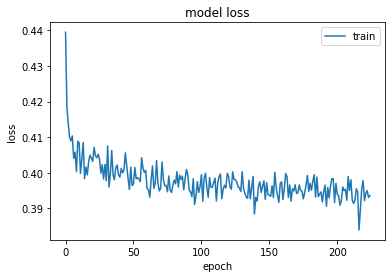

In [65]:
## Run 5-fold cross-validation to get average performance characteristics
unit = 32
ratio = 0.5
epoch = 225
(auroc_list, other_metric_list) = kfold_validation(unit, ratio, epoch, X_train_transformed, y_train, 'patient-id', \
                                                   n_features=n_features, verbose=1)

In [66]:
## other_metric_list has precision, recall, accuracy, specificity, f1, threshold for metrics
ave_prec = np.mean([x[0] for x in other_metric_list])
print("average precision:" + str(ave_prec))

ave_recall = np.mean([x[1] for x in other_metric_list])
print("average recall:" + str(ave_recall))

ave_specificity = np.mean([x[3] for x in other_metric_list])
print("average specificity:" + str(ave_specificity))

ave_f1 = np.mean([x[4] for x in other_metric_list])
print("average F1:" + str(ave_f1))

average precision:0.33727258278364036
average recall:0.5610319035277568
average specificity:0.7837657977201651
average F1:0.41434094465067367


In [67]:
max_f1 = np.max([x[4] for x in other_metric_list])
print("max F1: " + str(max_f1))

max F1: 0.455621301775148


In [68]:
## Average metrics performance
print("unit: %d\tepoch: %d\tauroc_mean: %f\tauroc_std: %f"  % (unit, epoch, np.mean(auroc_list), np.std(auroc_list)))

unit: 32	epoch: 225	auroc_mean: 0.726906	auroc_std: 0.009539


In [69]:
auroc_list

[0.7341611900284848,
 0.736233604703754,
 0.7208137589506793,
 0.7322249393356697,
 0.7110973237238449]

In [1]:
import anamod

In [2]:
from anamod import TemporalModelAnalyzer

In [4]:
analyzer = TemporalModelAnalyzer(model, X_test_pad, y_predict, output_dir='/home/kravchen/Desktop/NH')

NameError: name 'model' is not defined